<a href="https://colab.research.google.com/github/MinseoYoo/Animal-Sentiment-Detection/blob/main/pet_efficientnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
import os
import random
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset, random_split
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models
from PIL import Image
import torchvision.transforms as transforms

In [ ]:
class EmotionDataset(Dataset):
    def __init__(self, root_dir, split='train', transform=None):
        self.root_dir = root_dir
        self.split = split
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.class_names = []

        # Gather all image paths and their corresponding labels
        for class_name in os.listdir(root_dir):
            class_dir = os.path.join(root_dir, class_name)
            if os.path.isdir(class_dir):
                self.class_names.append(class_name)
                for img_name in os.listdir(class_dir):
                    img_path = os.path.join(class_dir, img_name)
                    if img_path.endswith(('.png', '.jpg', '.jpeg')):
                        self.image_paths.append(img_path)
                        self.labels.append(class_name)

        # Split the dataset into train, valid, and test
        dataset_size = len(self.image_paths)
        indices = list(range(dataset_size))
        random.shuffle(indices)
        train_split = int(0.75 * dataset_size)
        valid_split = int(0.15 * dataset_size) + train_split
        if split == 'train':
            self.indices = indices[:train_split]
        elif split == 'valid':
            self.indices = indices[train_split:valid_split]
        elif split == 'test':
            self.indices = indices[valid_split:]
        else:
            raise ValueError("Split must be 'train', 'valid', or 'test'")

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        img_path = self.image_paths[self.indices[idx]]
        image = Image.open(img_path).convert('RGB')
        label = self.class_names.index(self.labels[self.indices[idx]])

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ColorJitter(),
    transforms.RandomAdjustSharpness(0),
    transforms.RandomAutocontrast(),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [ ]:
# Create dataset instances
root_dir = '/content/drive/MyDrive/Colab Notebooks/비타민 14기/여름 CV/pet_kaggle'  # Replace with the path to your dataset

train_dataset = EmotionDataset(root_dir=root_dir, split='train', transform=train_transform)
valid_dataset = EmotionDataset(root_dir=root_dir, split='valid', transform=test_transform)
test_dataset = EmotionDataset(root_dir=root_dir, split='test', transform=test_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

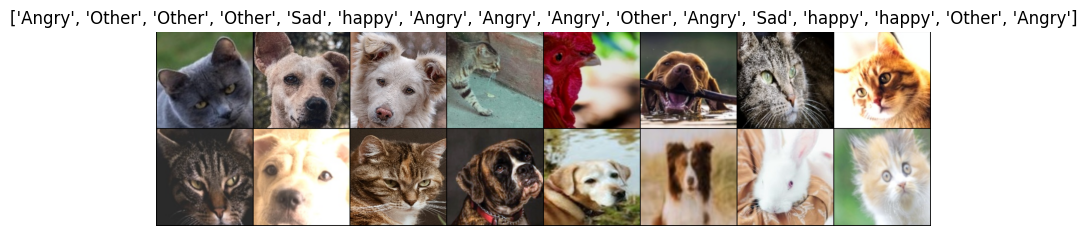

In [ ]:
import matplotlib.pyplot as plt

# Function to display images
def imshow(img, title):
    npimg = img.numpy()
    plt.figure(figsize=(10, 10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.axis('off')
    plt.show()

# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Create a grid from the batch
out = torchvision.utils.make_grid(images)

# Display images and their labels
imshow(out, title=[train_dataset.class_names[x] for x in labels])

## 모델 전이학습

In [ ]:
!pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nv

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained('efficientnet-b0')

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 91.1MB/s]


Loaded pretrained weights for efficientnet-b0


In [ ]:
image_size = EfficientNet.get_image_size('efficientnet-b0')
print(image_size)

224


In [ ]:
def train_and_evaluate(model, train_loader, valid_loader, num_epochs=5, device='cuda'):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-5)
    exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0

        # Training loop
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        avg_train_loss = train_loss / len(train_loader)
        train_accuracy = 100 * correct_train / total_train
        print(f"Epoch {epoch+1}, Training Loss: {avg_train_loss:.3f}, Training Accuracy: {train_accuracy:.3f}%")

        # Validation loop
        model.eval()
        valid_loss = 0.0
        correct_valid = 0
        total_valid = 0
        with torch.no_grad():
            for images, labels in valid_loader:
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                valid_loss += loss.item()

                # Calculate accuracy
                _, predicted = torch.max(outputs, 1)
                total_valid += labels.size(0)
                correct_valid += (predicted == labels).sum().item()

        avg_valid_loss = valid_loss / len(valid_loader)
        valid_accuracy = 100 * correct_valid / total_valid
        print(f"Epoch {epoch+1}, Validation Loss: {avg_valid_loss:.3f}, Validation Accuracy: {valid_accuracy:.3f}%")

In [ ]:
train_and_evaluate(model, train_loader, valid_loader, 20)

Epoch 1, Training Loss: 0.008, Training Accuracy: 99.733%
Epoch 1, Validation Loss: 0.032, Validation Accuracy: 98.667%
Epoch 2, Training Loss: 0.020, Training Accuracy: 99.200%
Epoch 2, Validation Loss: 0.024, Validation Accuracy: 98.000%
Epoch 3, Training Loss: 0.029, Training Accuracy: 98.667%
Epoch 3, Validation Loss: 0.065, Validation Accuracy: 96.000%
Epoch 4, Training Loss: 0.025, Training Accuracy: 99.200%
Epoch 4, Validation Loss: 0.024, Validation Accuracy: 99.333%
Epoch 5, Training Loss: 0.018, Training Accuracy: 99.600%
Epoch 5, Validation Loss: 0.076, Validation Accuracy: 97.333%
Epoch 6, Training Loss: 0.032, Training Accuracy: 99.067%
Epoch 6, Validation Loss: 0.057, Validation Accuracy: 97.333%
Epoch 7, Training Loss: 0.013, Training Accuracy: 99.600%
Epoch 7, Validation Loss: 0.054, Validation Accuracy: 98.000%
Epoch 8, Training Loss: 0.011, Training Accuracy: 99.600%
Epoch 8, Validation Loss: 0.030, Validation Accuracy: 98.667%
Epoch 9, Training Loss: 0.022, Training 